In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

In [0]:
# Creating and converting dataset to tensorflow
path = tf.keras.utils.get_file('dracula.txt', 'http://www.gutenberg.org/cache/epub/345/pg345.txt')
text = open(path, 'rb').read().decode(encoding='utf-8')
vocabulary = sorted(set(text))
vocabulary_size = len(vocabulary)

In [3]:
# map unique characters to indices and vice versa
charMapping = {u:i for i, u in enumerate(vocabulary)}
indiceMapping = np.array(vocabulary)
text_as_int = np.array([charMapping[c] for c in text])

sequence_length = 100
examples_per_epoch = len(text)//sequence_length # floor division
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(sequence_length+1, drop_remainder=True)

num_of_characters = len(text)
num_of_vocabulary = len(vocabulary)
print("Total Characters: ", num_of_characters)
print("Total Vocabulary: ", num_of_vocabulary)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Total Characters:  883114
Total Vocabulary:  102


In [0]:
BATCH_SIZE = 128
steps_per_epoch = examples_per_epoch//BATCH_SIZE # floor division
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [5]:
# Build model
embedding_dimension = 256
rnn_units = 1024

lstm = tf.keras.layers.CuDNNLSTM # fast LSTM implementation backed by cuDNN

def build_model(vocab_size, embedding_dim, units, batch_size, drop_out):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]), # Input layer
    lstm(rnn_units, # Hidden layer 1
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 2
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 3
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    lstm(rnn_units, # Hidden layer 4
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dropout(drop_out),
    tf.keras.layers.Dense(vocab_size) # Output layer
  ])
  return model

model = build_model(
  vocab_size = vocabulary_size, 
  embedding_dim=embedding_dimension, 
  units=rnn_units, 
  batch_size=BATCH_SIZE,
  drop_out=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Validate the model
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [7]:
# Train the model
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

model.compile(tf.train.AdamOptimizer(), loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS=100
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Prediction shape:  (128, 100, 102)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.6255913
Epoch 1/100
67/68 [============================>.] - ETA: 0s - loss: 3.2563WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
68/68 [==============================] - 58s 847ms/step - loss: 3.2550
Epoch 2/100
68/68 [==============================] - 55s 808ms/step - loss: 3.1448
Epoch 3/100
68/68 [==============================] - 54s 797ms/step - loss: 3.1391
Epoch 4/100
68/68 [==============================] - 54s 801ms/step - loss: 3.1371
Epoch 5/100
68/68 [==============================] - 55s 802ms/step - loss: 3.1351
Epoch 6/100
68/68 [=================

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocabulary_size, embedding_dimension, rnn_units, batch_size=1, drop_out=0.2)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
# Generate text algorithm
def generate_text(model, num_char_to_generate, temperature, start_string):
  # Converting our start string to numbers (vectorizing) 
  input_eval = [charMapping[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  for i in range(num_char_to_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(indiceMapping[predicted_id])

  return (start_string + ''.join(text_generated))

In [10]:
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.

print(generate_text(model, 5000, .6, "Dracula moved to Copenhagen because "))

Instructions for updating:
Use tf.random.categorical instead.
Dracula moved to Copenhagen because zVVGèèGGè8&èèèzM&èèâG&èâëèzQèè&&ëèzzèèKèKè8zèèèè&èë)VVèGèèMâèèFèè)èè>VèèèJQQèè7QJèèèKQèfè>GèzQèèèQèëJQèè1ëKJGèGGJèGFè{>è>JGèè>4èKVVQG}èGAQ}BQèGèGGè>èèGQKQèè=BèGQèè)QèGQèèGQèGQQGèGQèGEGGQ9èGBGèGGQGèGGQGGGGèGGGGGGGèGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGfBGGGGGGGGGèGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGBGGfGGG&VJèGGGKGKGGGGGKGGGGGGG(GQGGG}GGGGGGGG9GGGGGGGGGGGGGGGGGGGGGèGGGGGGGGGGGGGGGGGGGGGWGGAGGGGGGGGGGGGGGGGGGG9GGGGGGGGGGGGGGGGGGGGGGGGGGG6GGG9GGGG9GG1G=GGGGGGGGGGGGGGGGGGGGGGQGGGGGGGGGGGGGGGGQGGGGGGGGGGGGGGGGGGGGGG)GGGGKGGGGGGGGGG=GGGGGGGGGGGGGGGGGGGGBGGGGBGGGKGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGQGGG5GGGGGGGGG99FGGGGGGGGGGG9GGGGGGGQGGGGGGGGGGGGGGGèGGGGGKGGGGQGGGGGGGGëGGGGGGGGGGGGGGGGáGGGGGGGGëGGGGGGGGGGGGëKGKGèGQQGGGGGGGGGG9GGGGGF9GGGGGGGGGG9GGQGGGG0GFGGGG=GGGG5GGG>VKGGGGGGGGGGG{GG>GGGèGGGGGGGGGGGGGGGGGGGGGGGGGQGGGGGGKG=GGEGWVVVV{GKGGQGGGGGGGQGG;QQSVVèGGGGG0GQGKGV8GQQGGGGQQ=GGGGGKVVV#G{GGQQGGGG

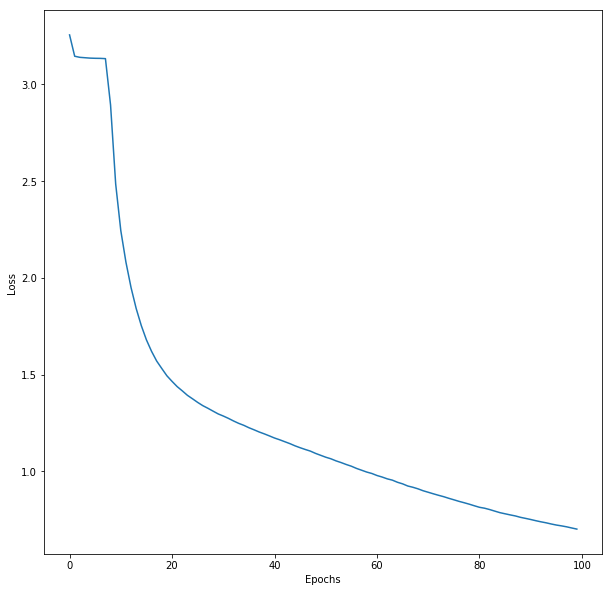

In [11]:
import matplotlib.pyplot as plt
import numpy as np
loss = history.history['loss']
newLoss = np.squeeze(loss)
plt.figure(figsize=(10,10))
plt.plot(newLoss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()